In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Nacitanie iris datasetu
# X - features
# y - triedy
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [36]:
print("Dataset shape:", X.shape)
print("Labels:", set(y))
print("Classes:", iris['target_names'])

Dataset shape: (150, 4)
Labels: {0, 1, 2}
Classes: ['setosa' 'versicolor' 'virginica']


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
def create_scatter_plot(X, y, features, title):
    # Set up the figure and axis
    plt.figure(figsize=(12, 10))
    plt.suptitle(title, fontsize=16)

    # Create a scatter plot for each pair of features
    plot_number = 1
    for i in range(len(features)):
        for j in range(len(features)):
            if i < j:
                plt.subplot(2, 3, plot_number)
                for target in np.unique(y):
                    subset = X[y == target]
                    plt.scatter(subset[:, i], subset[:, j], label=iris.target_names[target])
                plt.xlabel(features[i])
                plt.ylabel(features[j])
                plt.legend()
                plot_number += 1

    plt.show()

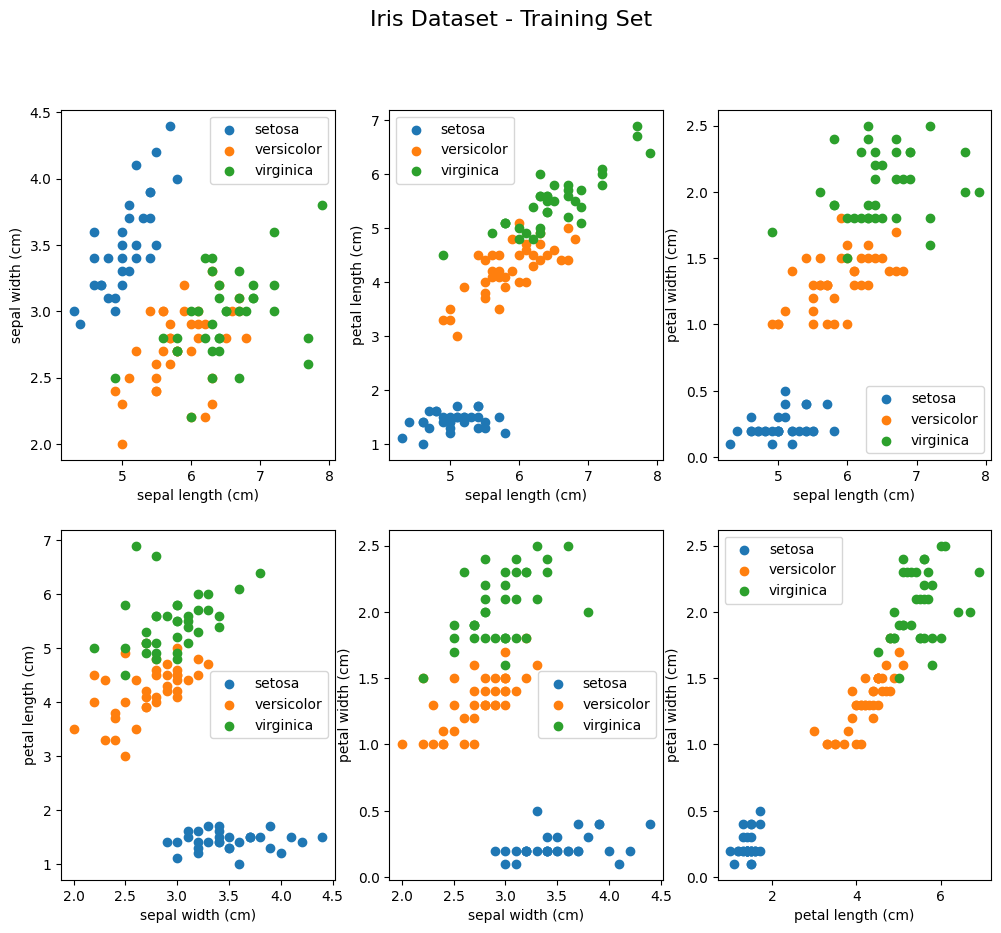

In [39]:
# Visualize the training set
create_scatter_plot(X_train, y_train, iris.feature_names, 'Iris Dataset - Training Set')

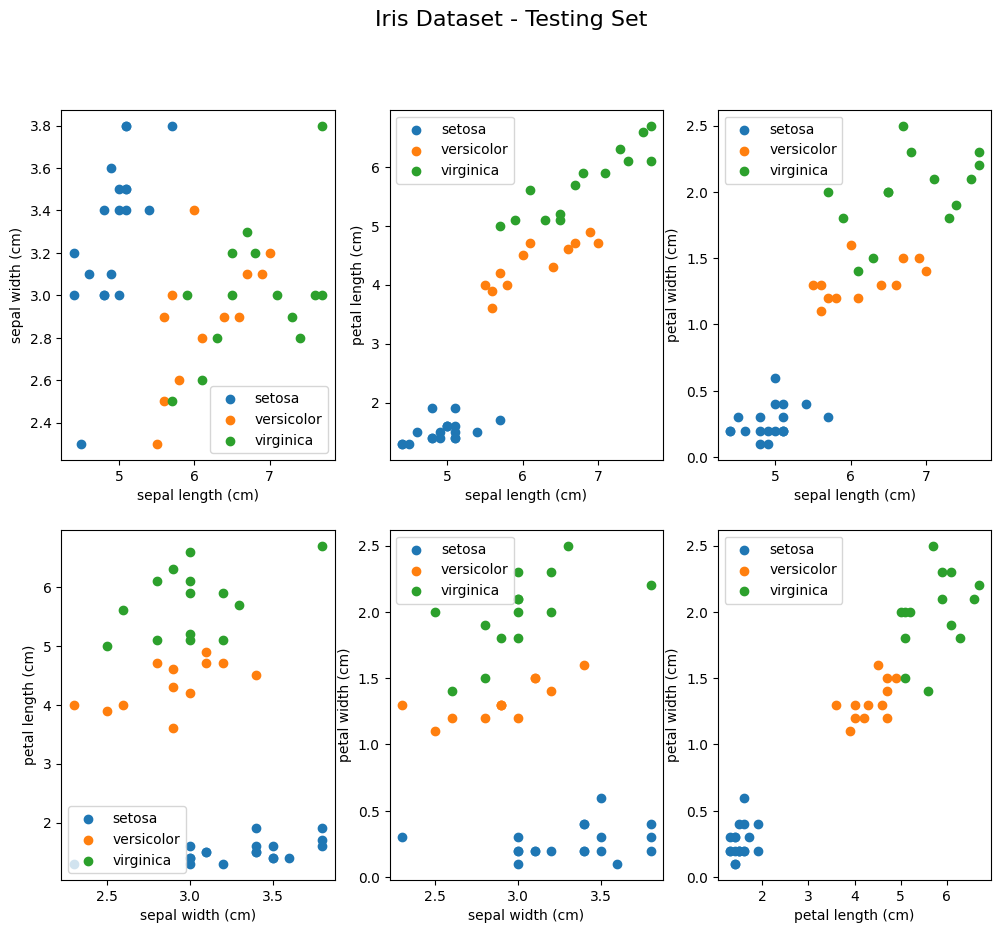

In [40]:
# Visualize the testing set
create_scatter_plot(X_test, y_test, iris.feature_names, 'Iris Dataset - Testing Set')

In [25]:
# Standardize the dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [27]:
# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [28]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # First hidden layer
        self.fc1 = nn.Linear(4, 10) # 4 input features, 10 neurons in the first hidden layer
        # Second hidden layer
        self.fc2 = nn.Linear(10, 10) # 10 neurons in the second hidden layer
        # Output layer
        self.fc3 = nn.Linear(10, 3) # 3 output classes

        # Rectified linear unit
        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply ReLU activation function after each hidden layer
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        # No activation function is applied at the output layer here
        # This will be done later in combination with the loss function
        x = self.fc3(x)
        return x

In [29]:
model = Classifier()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
# Training loop
for epoch in range(100):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 1.1544547080993652
Epoch 2, Loss: 1.189283013343811
Epoch 3, Loss: 1.104901909828186
Epoch 4, Loss: 1.2144722938537598
Epoch 5, Loss: 1.0799520015716553
Epoch 6, Loss: 0.8540228605270386
Epoch 7, Loss: 1.0951600074768066
Epoch 8, Loss: 0.9620911478996277
Epoch 9, Loss: 1.018502116203308
Epoch 10, Loss: 0.9494093656539917
Epoch 11, Loss: 0.8438916802406311
Epoch 12, Loss: 0.8377271890640259
Epoch 13, Loss: 0.8880936503410339
Epoch 14, Loss: 0.8132250308990479
Epoch 15, Loss: 0.8637619614601135
Epoch 16, Loss: 0.8180795907974243
Epoch 17, Loss: 0.8076168298721313
Epoch 18, Loss: 0.7450158596038818
Epoch 19, Loss: 0.9717578887939453
Epoch 20, Loss: 0.6301088929176331
Epoch 21, Loss: 0.5816118121147156
Epoch 22, Loss: 0.7210111021995544
Epoch 23, Loss: 0.4798811376094818
Epoch 24, Loss: 0.5540657043457031
Epoch 25, Loss: 0.461273729801178
Epoch 26, Loss: 0.6674730777740479
Epoch 27, Loss: 0.6671546697616577
Epoch 28, Loss: 0.5646836757659912
Epoch 29, Loss: 0.500783383846283

In [31]:
def evaluate_model(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [32]:
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy: {accuracy}%')

sample_inputs = torch.tensor([[5.1, 3.5, 1.4, 0.2], [6.7, 3.0, 5.2, 2.3]], dtype=torch.float32)
sample_inputs = scaler.transform(sample_inputs)  # Apply the same scaling as the training data
sample_inputs = torch.tensor(sample_inputs, dtype=torch.float32)

model.eval()
with torch.no_grad():
    sample_outputs = model(sample_inputs)
    _, predicted = torch.max(sample_outputs, 1)
print("Predictions:", predicted.numpy())

Accuracy: 97.77777777777777%
Predictions: [2 2]
